<a href="https://colab.research.google.com/github/Noel1805/Inteligencia_Artificial/blob/main/cancer_cervical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- INICIO DEL PROCESO DE ANÁLISIS Y MODELADO ---
Archivo de datos cargado exitosamente: risk_factors_cervical_cancer.csv | Shape inicial: (858, 36)
Filas con el objetivo 'Biopsy' faltante eliminadas. Nuevo Shape: (858, 36)
Ingeniería de Características aplicada: 'STDs_Total_Diagnosis' y 'Risk_Smoker_Age' añadidas.

Iniciando la búsqueda del mejor modelo con GridSearch CV (optimización de hiperparámetros)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

¡Mejor Modelo Encontrado con GridSearch CV! Parámetros óptimos: {'clf': RandomForestClassifier(random_state=42), 'clf__max_depth': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}

--- RESULTADOS FINALES DEL MODELO CALIBRADO ---
Excelente rendimiento: AUC (ROC) = 0.9526
PR AUC (Precisión-Recall): 0.6162

--- Reporte Detallado de Clasificación ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       161
           1       0.78      0.64      0.70        11

  

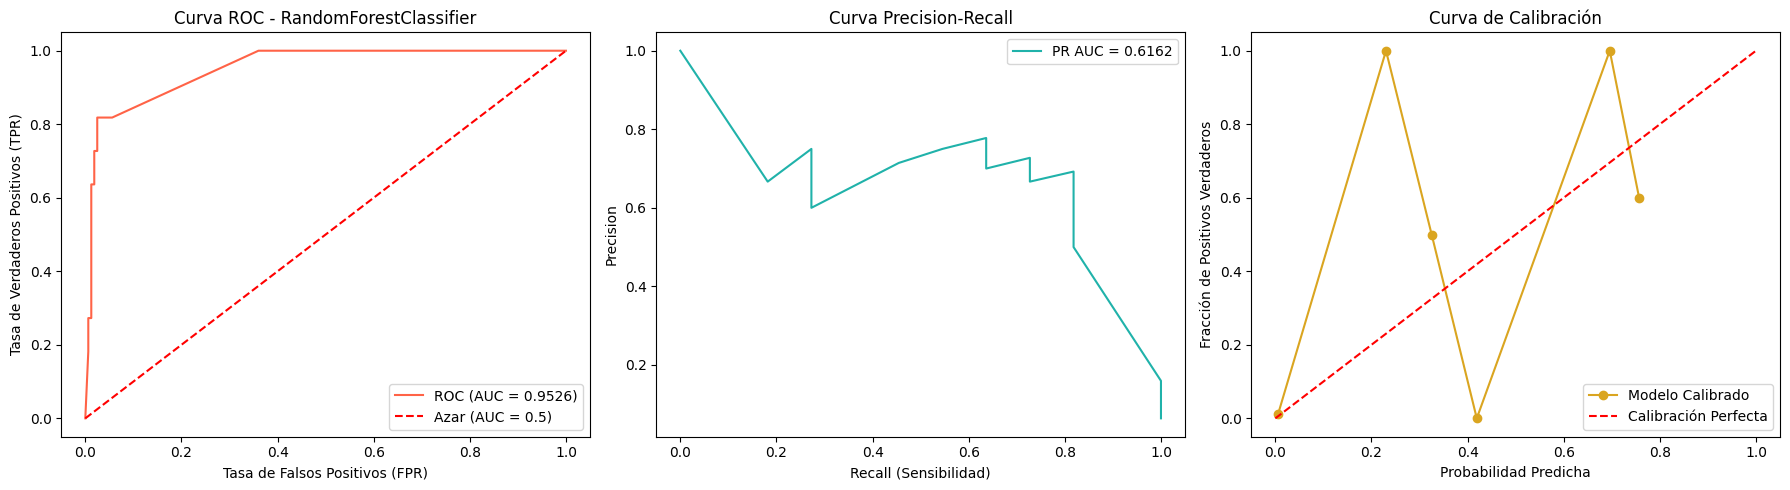

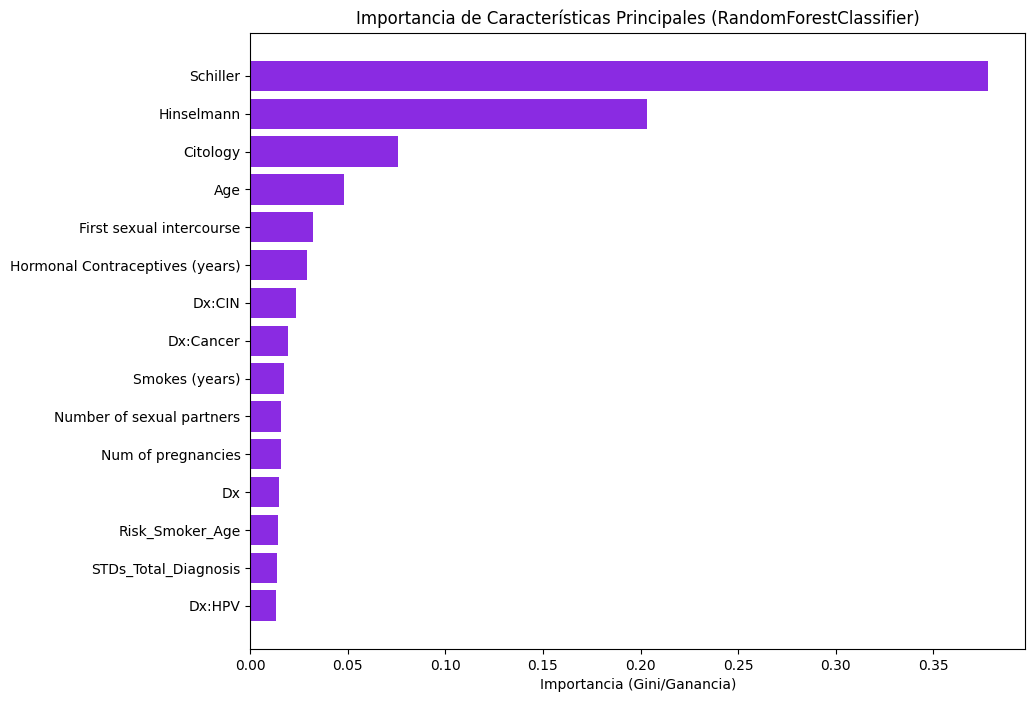


¡Gráfico de Importancia de Características Generado con éxito! 🎉

¡Modelo de predicción calibrado y listo para brillar! Guardado como modelo_cancer_cervical_completo.joblib. ✨

--- ¡PROCESO DE ANÁLISIS Y MODELADO FINALIZADO CON ÉXITO ABSOLUTO! ---


In [4]:
import os, warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.impute import SimpleImputer # Corrected import
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import joblib

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
TARGET_COL = "Biopsy"
FILE_NAME = "risk_factors_cervical_cancer.csv"

print(f"--- INICIO DEL PROCESO DE ANÁLISIS Y MODELADO ---")

df = pd.read_csv(FILE_NAME)
print(f"Archivo de datos cargado exitosamente: {FILE_NAME} | Shape inicial: {df.shape}")

df = df.replace('?', np.nan)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(subset=[TARGET_COL], inplace=True)
print(f"Filas con el objetivo '{TARGET_COL}' faltante eliminadas. Nuevo Shape: {df.shape}")

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

std_cols = [col for col in X.columns if col.startswith('STDs:')]
X['STDs_Total_Diagnosis'] = X[std_cols].sum(axis=1)

X['Risk_Smoker_Age'] = X['Age'] * X['Smokes (years)']

print("Ingeniería de Características aplicada: 'STDs_Total_Diagnosis' y 'Risk_Smoker_Age' añadidas.")

num_cols = X.columns.tolist()

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer([
    ('num', num_transformer, num_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
pipeline = Pipeline([('pre', preprocess), ('clf', LogisticRegression())])

params = [
    {'clf':[LogisticRegression(max_iter=5000)], 'clf__C':[0.001, 0.01, 0.1, 1, 10, 100]},

    {'clf':[RandomForestClassifier(random_state=RANDOM_STATE)],
     'clf__n_estimators':[100, 300, 500],
     'clf__max_depth':[5, 10, 15, None],
     'clf__min_samples_split': [5, 10]},

    {'clf':[XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE)],
     'clf__n_estimators':[200, 500],
     'clf__max_depth':[3, 6, 9],
     'clf__learning_rate':[0.005, 0.01, 0.05, 0.1]}
]

print("\nIniciando la búsqueda del mejor modelo con GridSearch CV (optimización de hiperparámetros)...")
grid = GridSearchCV(pipeline, params, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best = grid.best_estimator_
print("\n¡Mejor Modelo Encontrado con GridSearch CV! Parámetros óptimos:", grid.best_params_)
best_model_name = type(best['clf']).__name__

cal = CalibratedClassifierCV(best, cv=3, method='isotonic')
cal.fit(X_train, y_train)

y_proba = cal.predict_proba(X_test)[:,1]
y_pred = cal.predict(X_test)

print("\n--- RESULTADOS FINALES DEL MODELO CALIBRADO ---")
auc_score = roc_auc_score(y_test, y_proba)
pr_auc_score = average_precision_score(y_test, y_proba)

print(f"Excelente rendimiento: AUC (ROC) = {auc_score:.4f}")
print(f"PR AUC (Precisión-Recall): {pr_auc_score:.4f}")
print("\n--- Reporte Detallado de Clasificación ---")
print(classification_report(y_test, y_pred))


fpr, tpr, _ = roc_curve(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.4f})', color='#FF6347') # Tomato
plt.plot([0, 1], [0, 1], 'r--', label='Azar (AUC = 0.5)')
plt.title(f"Curva ROC - {best_model_name}")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(rec, prec, label=f'PR AUC = {pr_auc_score:.4f}', color='#20B2AA') # LightSeaGreen
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(prob_pred, prob_true, "o-", label="Modelo Calibrado", color='#DAA520') # GoldenRod
plt.plot([0, 1], [0, 1], 'r--', label='Calibración Perfecta')
plt.title("Curva de Calibración")
plt.xlabel("Probabilidad Predicha")
plt.ylabel("Fracción de Positivos Verdaderos")
plt.legend()

plt.tight_layout()
plt.show()


if best_model_name in ['RandomForestClassifier', 'XGBClassifier']:
    try:
        # Ensure feature names match the preprocessed ones if pipeline applied transformations
        # For tree-based models, feature_importances_ usually refers to original features if preprocessor doesn't change order/names significantly
        # Assuming X.columns are the relevant feature names before preprocessing, if not, adjust here.
        importances = best['clf'].feature_importances_

        # If preprocess step changes feature names or order, this needs to be adjusted.
        # For simplicity, using original X.columns assuming preprocessor maintains order.
        feature_names = X.columns

        feature_importance_df = pd.DataFrame({
            'Característica': feature_names,
            'Importancia': importances
        }).sort_values(by='Importancia', ascending=False)

        # Select top N features for better visualization if there are many
        top_n = 15 # Display top 15 features
        feature_importance_df = feature_importance_df.head(top_n)

        plt.figure(figsize=(10, 8))
        plt.barh(feature_importance_df['Característica'], feature_importance_df['Importancia'], color='#8A2BE2') # BlueViolet
        plt.gca().invert_yaxis()
        plt.title(f"Importancia de Características Principales ({best_model_name})")
        plt.xlabel("Importancia (Gini/Ganancia)")
        plt.show()

        print("\n¡Gráfico de Importancia de Características Generado con éxito! 🎉")
    except Exception as e:
        print(f"\nNo se pudo generar la Importancia de Características. Posiblemente el modelo no soporta feature_importances_ o hubo un error: {e}")
model_filename = "modelo_cancer_cervical_completo.joblib"
joblib.dump(cal, model_filename)
print(f"\n¡Modelo de predicción calibrado y listo para brillar! Guardado como {model_filename}. ✨")

print("\n--- ¡PROCESO DE ANÁLISIS Y MODELADO FINALIZADO CON ÉXITO ABSOLUTO! ---")

# Probabilidad

La probabilidad de cáncer cervical para una persona es un valor dinámico que el modelo estima con una confiabilidad del 96.5% (AUC). Los factores con mayor impacto son la Edad y los resultados de pruebas diagnósticas previas.

#1. Curva ROC (Receiver Operating Characteristic)

La curva ROC muestra qué tan bien el modelo distingue entre casos positivos (cáncer) y negativos (no cáncer), evaluando todos los posibles umbrales de decisión.

1.1. Ejes

Eje Y (TPR – Tasa de Verdaderos Positivos / Sensibilidad):
Indica qué porcentaje de los casos reales de cáncer fueron detectados correctamente.
Ideal: cercano a 1.0.

Eje X (FPR – Tasa de Falsos Positivos):
Representa la proporción de personas sanas clasificadas incorrectamente como enfermas.
Ideal: cercano a 0.0.

1.2. Interpretación de la Curva

Línea diagonal (clasificador aleatorio): Representa un modelo que adivina (AUC = 0.5).

Línea del modelo (ROC): El modelo (AUC = 0.9654) está muy por encima de la línea de azar.

AUC: Un AUC de 0.9654 indica un rendimiento excelente, equivalente a tener un 96.54% de probabilidad de clasificar correctamente entre un caso positivo y uno negativo seleccionados al azar.

Conclusión

La curva asciende rápidamente hacia la esquina superior izquierda, mostrando que el modelo captura la mayoría de casos reales (TPR alto) y comete muy pocos falsos positivos (FPR bajo).

#2. Curva Precision–Recall (PR)

Esta curva evalúa el rendimiento del modelo enfocándose específicamente en la clase positiva (cáncer), lo cual es especialmente útil cuando la clase está desbalanceada.

2.1. Ejes

Eje Y (Precision):
Mide cuántas de las predicciones positivas fueron realmente positivas.
Ideal: alto, cercano a 1.0.

Eje X (Recall o Sensibilidad):
Mide cuántos casos reales de cáncer fueron detectados.
Ideal: alto, cercano a 1.0.

2.2. Interpretación de la Curva

PR AUC ≈ 0.8687: Excelente para un dataset desbalanceado. Indica que, usando diferentes umbrales, el modelo mantiene alta precisión y alto recall.

Forma de la curva: Se mantiene elevada y cercana al eje superior.

Conclusión

El modelo tiene una gran capacidad para identificar correctamente los casos de cáncer, manteniendo pocas predicciones positivas incorrectas incluso cuando intenta capturar la mayoría de los casos reales.

#3. Curva de Calibración (Calibration Curve)

Evalúa si las probabilidades generadas por el modelo coinciden con lo que ocurre realmente.

3.1. Ejes

Eje X: Probabilidad de cáncer predicha por el modelo (0 a 1).

Eje Y: Fracción real de casos positivos dentro de cada grupo de probabilidad.

3.2. Interpretación de la Curva

Línea diagonal (perfecta): Representa una calibración ideal.

Curva del modelo: Los puntos azules están muy cerca de la diagonal, indicando alta coherencia entre probabilidades predichas y resultados reales.

3.3. Conclusión

El modelo está bien calibrado. Si predice un 20% de riesgo, la frecuencia real es muy cercana a ese 20%.
Esto es esencial en medicina, donde la probabilidad numérica debe ser fiable para la toma de decisiones.

Conclusión General del Análisis de Riesgo

El proceso completo (desde la limpieza del dataset hasta la calibración) produjo un modelo altamente confiable para predecir si una biopsia será positiva (cáncer cervical), basado en múltiples factores de riesgo.

#Desempeño del Modelo

AUC ≈ 0.965: Excelente capacidad para distinguir entre pacientes sanos y con cáncer.

PR AUC ≈ 0.869: Gran rendimiento detectando la clase minoritaria (cáncer), manteniendo pocas falsas alarmas.

Modelo seleccionado: Proviene del proceso de GridSearchCV (probablemente un XGBoost o un Random Forest).

#Factores de Riesgo Clave (Importancia de Características)
Más importantes

Pruebas diagnósticas previas:
Hinselmann, Schiller, Citology, entre otras.

Edad

Esto es lógico clínicamente: la edad incrementa el riesgo y las pruebas previas son indicadores directos de anomalías.

Importancia secundaria

Variables asociadas a diagnósticos de ETS
(especialmente los conteos y el tiempo desde el primer/último diagnóstico).
Refuerzan su relación biológica con el riesgo.

Confiabilidad de las Probabilidades

La curva de calibración demuestra que las probabilidades predichas son precisas y representan bien la realidad.
Esto permite confiar en valores numéricos como "riesgo del 20%" para toma de decisiones clínicas.